In [1]:
import pandas as pd
import regex as re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import ahocorasick

import torch
from transformers import T5ForConditionalGeneration, AutoTokenizer, MT5ForConditionalGeneration, get_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
#from fairseq.optim.adafactor import Adafactor

from tqdm import tqdm
import matplotlib.pyplot as plt

from copy import deepcopy

In [2]:
# CONSTANTS:

SEP_TOKEN = '▁<extra_id_0>'
INPUT_PREFIX = ''

NUM_OF_SPLITS = 25

ATTACHMENT_TOKEN = '▁<extra_id_1>'
LABEL_PREFIX_TOKEN = ATTACHMENT_TOKEN

USED_MODEL_NAME = 'cointegrated/rut5-small'

SEQ_MAX_LENGTH = 300
ANSWER_MAX_LENGTH = 170
BATCH_SIZE = 4
EVAL_BATCH_SIZE = 24

ENABLE_LABEL_FIX = True

LOCAL_NUM_EPOCHS = 2

In [3]:
tokenizer = AutoTokenizer.from_pretrained (USED_MODEL_NAME)

device = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')
#device = torch.device ('cpu')

model = MT5ForConditionalGeneration.from_pretrained (USED_MODEL_NAME)

model.to (device)
print (model.device)

num_epochs = 50
#training_steps = len (train_data ['input_ids']) // BATCH_SIZE * num_epochs
#warmup_steps = int (training_steps * 0.1)
#print (f'Suggested train steps: {training_steps}\n\t warmup steps: {int (training_steps * 0.05)} - {int (training_steps * 0.1)}')

#optimizer = AdamW (model.parameters (), lr = 1e-5)#, weight_decay = 0.05)
optimizer = AdamW (filter (lambda p: p.requires_grad, model.parameters ()), lr = 1e-4, weight_decay = 0.01)
#optimizer = Adafactor (model.parameters (), lr = 3e-5, scale_parameter = False, relative_step = False, weight_decay = 0.02)
#scheduler = get_scheduler ('linear', optimizer = optimizer, num_warmup_steps = warmup_steps, num_training_steps = training_steps)

metrics = {'train_loss': [], 'val_loss': [], 'precision': [], 'recall': [], 'f1_score': []}

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
c:\Users\Enfi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


cuda:0


In [4]:

# FUNCTIONS:

def split_text (text, segments, delimiters = ['...', '.', '?!', '?', '!']):

    delimiters_pattern = '|'.join (map (re.escape, delimiters))
    
    paragraphs = re.split (f'(?<=\n[ ]*)', text)
    
    sentences_with_segments = []
    
    current_start_index = 0

    for paragraph in paragraphs:

        sentences = re.split (f'(?<=[{delimiters_pattern}] )(?=[A-ZА-ЯЁ])', paragraph)#.strip ())

        for sentence in sentences:

            start_index = current_start_index
            end_index = start_index + len (sentence)

            matched_segments = [
                text [start: end] for start, end in segments if start >= start_index and end <= end_index
            ]
            sentences_with_segments.append ((sentence, matched_segments))

            current_start_index = end_index
    
    return sentences_with_segments

def create_parallels (data_lst, labels_lst):
    parallel_text = []
    parallel_label = []
    for i in range (len (data_lst)):
        text = data_lst [i]
        segments = labels_lst [i]
        splitted = split_text (text, segments)
        for sentence, terms in splitted:
            parallel_text.append (INPUT_PREFIX + sentence)
            constructed_label = LABEL_PREFIX_TOKEN
            for term in terms:
                constructed_label += SEP_TOKEN + term.strip ()
            parallel_label.append (constructed_label)
    return parallel_text, parallel_label


def label_constructor (labels):
    res = []
    for label in labels:
        one_label = []
        for start, end, cls in label:
            one_label.append ([start, end])
        res.append (one_label)
    return res


def one_finder (text, phrases):

    if len (phrases) == 1 and '' in phrases:
        return []

    A = ahocorasick.Automaton ()
    
    for idx, phrase in enumerate (phrases):
        A.add_word (phrase, (idx, phrase))
    
    A.make_automaton ()
    
    found = []
    for end_index, (idx, phrase) in A.iter (text):
        start_index = end_index - len (phrase) + 1

        if start_index > 0 and text [start_index - 1].isalpha ():
            continue
        if end_index + 1 < len (text) and text [end_index + 1].isalpha ():
            continue

        found.append ((start_index, end_index + 1, phrase))
    
    return found

def make_attachment (text, dictionary_terms):
    found = one_finder (text, dictionary_terms)
    found_terms = [item [2] for item in found]
    res = text + ATTACHMENT_TOKEN
    for term in found_terms:
        res += SEP_TOKEN + term
    return res

def attach_dictionary_foundings (texts, dictionary_terms):
    res_texts = []
    for text in tqdm (texts):
        res_texts.append (make_attachment (text, dictionary_terms))
    return res_texts

def replace_padding (labels):
    for i in range (0, len (labels ['input_ids'])):
        labels ['input_ids'] [i] = torch.tensor ([labl if labl != 0 else - 100 for labl in labels ['input_ids'] [i]])

    return labels

class Seq2SeqDataset (Dataset):
    def __init__ (self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__ (self, idx):
        return {
            'input_ids': self.encodings ['input_ids'] [idx],
            'attention_mask': self.encodings ['attention_mask'] [idx],
            'labels': self.labels ['input_ids'] [idx]
        }

    def __len__ (self):
        return len (self.encodings ['input_ids'])

def get_set (tensor, ground_truth = True, tokenizer = tokenizer):

    separator: str
    if SEP_TOKEN == '▁<extra_id_0>': separator = '<extra_id_0>'
    else: separator = SEP_TOKEN

    res: set

    if ground_truth:
        eos_idx = (tensor == 1).nonzero ()
        if eos_idx.numel () > 0:
            eos_idx = int (eos_idx [0] [0])
        else:
            eos_idx = len (tensor)
        seq = tensor [:eos_idx]
    
    else:
        seq = tensor [tensor != 0]
        seq = seq [seq != - 100]
        seq = seq [seq != 1]
    
    txt = tokenizer.decode (seq)
    res = set ([item.strip () for item in txt.split (separator)])

    if len (res) > 1:
        res -= set ([''])
    res -= set ([LABEL_PREFIX_TOKEN [1:]])
    if len (res) == 0: res |= set ([''])

    return res


def sanity_check (preds, labels, to_print = False):

    tps_sum = 0
    fps_sum = 0
    fns_sum = 0 

    for i in range (len (labels)):
        predicted_set = get_set (preds [i], ground_truth = False)
        true_set = get_set (labels [i])

        if to_print: print (f'True: {true_set}\nPred: {predicted_set}')

        tps_sum += len (true_set & predicted_set)  # Истинно положительные
        fps_sum += len (predicted_set - true_set)     # Ложноположительные
        fns_sum += len (true_set - predicted_set)     # Ложноотрицательные

    precision = tps_sum / (tps_sum + fps_sum) if (tps_sum + fps_sum) > 0 else 0
    recall = tps_sum / (tps_sum + fns_sum) if (tps_sum + fns_sum) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [12]:
df = pd.read_json ('train_t1_v1.jsonl', lines = True)
df.drop (columns = ['id', 'keywords'], inplace = True)
print (df.head ())
print ()
df_2 = pd.read_json ('./test_data/test1_t12_full_v2.jsonl', lines = True)
df_2 = df_2 [['text', 'label']]
print (df_2.head ())
print ()

val_data_txt, test_data_txt, val_labels_txt, test_labels_txt = train_test_split (df_2 ['text'], df_2 ['label'], test_size = 0.5, random_state = 14)

train_data_lst = df ['text'].tolist ()
train_labels_lst = df ['label'].tolist ()
train_parallel_text, train_parallel_labels = create_parallels (train_data_lst, train_labels_lst)

val_data_lst = val_data_txt.tolist ()
val_labels_lst = label_constructor (val_labels_txt)
val_parallel_text, val_parallel_labels = create_parallels (val_data_lst, val_labels_lst)

test_data_lst = test_data_txt.tolist ()
test_labels_lst = label_constructor (test_labels_txt)
test_parallel_text, test_parallel_labels = create_parallels (test_data_lst, test_labels_lst)

all_train_terms = set ()
for line in train_parallel_labels:
    all_train_terms |= set (line.split (SEP_TOKEN))
all_train_terms -= set ([''])
all_train_terms -= set ([LABEL_PREFIX_TOKEN])
print (f'Уникальных терминов во всём тренировочном наборе: {len (all_train_terms)}.\n')

val_parallel_text_new = attach_dictionary_foundings (val_parallel_text, all_train_terms)
test_parallel_text_new = attach_dictionary_foundings (test_parallel_text, all_train_terms)

val_data = tokenizer (val_parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (val_parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

test_data = tokenizer (test_parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
test_labels = tokenizer (test_parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    
    replaced = replace_padding (val_labels)
    val_labels = replaced

    replaced = replace_padding (test_labels)
    test_labels = replaced

val_dataset = Seq2SeqDataset (val_data, val_labels)
test_dataset = Seq2SeqDataset (test_data, test_labels)

val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)
test_loader = DataLoader (test_dataset, batch_size = EVAL_BATCH_SIZE)

                                                text  \
0  ABBYY Retrieval & Morphology Engine\nВ сообщен...   
1  Речевые формулы в диалоге\nПредложенная класси...   
2  Географические названия и полнотекстовые докум...   
3  Методы автоматического построения специализиро...   
4  Закономерности построения дискурсивной последо...   

                                               label  
0  [[0, 35], [6, 15], [18, 35], [29, 35], [69, 88...  
1  [[0, 15], [18, 25], [74, 99], [134, 140], [175...  
2  [[0, 23], [26, 50], [54, 68], [169, 190], [181...  
3  [[7, 63], [34, 63], [54, 63], [92, 128], [119,...  
4  [[26, 57], [62, 76], [251, 265], [266, 280], [...  

                                                text  \
0  АВТОМАТИЧЕСКИЙ АНАЛИЗ ТОНАЛЬНОСТИ ТЕКСТОВ НА О...   
1  InBASE: ТЕХНОЛОГИЯ ПОСТРОЕНИЯ ЕЯ-ИНТЕРФЕЙСОВ К...   
2  Выражение уважительности с помощью личных мест...   
3  ДА ЧЕРТ ЛИ В ДЕТАЛЯХ?.. МЕРА ДЛЯ ОЦЕНКИ СОВПАД...   
4  КОРПУСНАЯ ОЦЕНКА СОЧЕТАЕМОСТИ СЛОВ С ИСПОЛЬЗОВ...

100%|██████████| 695/695 [00:08<00:00, 80.46it/s]


In [6]:
def attach_model_foundings (texts, loader, model = model):

    model.eval ()
    val_preds = []
    with torch.no_grad ():
        for batch in loader:
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)

            outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length = SEQ_MAX_LENGTH)

            val_preds.extend (outputs)
            torch.cuda.empty_cache ()

    res_texts = []
    for iteration, text in tqdm (enumerate (texts)):
        predicted_set = get_set (val_preds [iteration], ground_truth = False)
        res_texts.append (make_attachment (text, predicted_set))
    return res_texts

In [ ]:
X_curr = data [test_indices [iteration] [1]]
y_curr = labels [test_indices [iteration] [1]]

train_data_lst = X_curr.tolist ()
train_labels_lst = y_curr.tolist ()
parallel_text, parallel_labels = create_parallels (train_data_lst, train_labels_lst)

train_data = tokenizer (parallel_text, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
train_labels = tokenizer (parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    replaced = replace_padding (train_labels)
    train_labels = replaced

train_dataset = Seq2SeqDataset (train_data, train_labels)
train_loader = DataLoader (train_dataset, batch_size = EVAL_BATCH_SIZE)

parallel_text_new = attach_model_foundings (parallel_text, train_loader, model)

if iteration < kf.n_splits - 1:

    X_next = data [test_indices [iteration + 1] [1]]
    y_next = labels [test_indices [iteration + 1] [1]]

    train_data_lst_next = X_next.tolist ()
    train_labels_lst_next = y_next.tolist ()
    parallel_text_next, parallel_labels_next = create_parallels (train_data_lst_next, train_labels_lst_next)

    train_data_next = tokenizer (parallel_text_next, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
    train_labels_next = tokenizer (parallel_labels_next, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

    if ENABLE_LABEL_FIX:
        replaced = replace_padding (train_labels_next)
        train_labels_next = replaced

    train_dataset_next = Seq2SeqDataset (train_data_next, train_labels_next)
    train_loader_next = DataLoader (train_dataset_next, batch_size = EVAL_BATCH_SIZE)

    parallel_text_new_next = attach_model_foundings (parallel_text_next, train_loader_next, model)

In [ ]:
kf = KFold (n_splits = NUM_OF_SPLITS)

data = df ['text']
labels = df ['label']

test_indices = list (kf.split (data))


iteration = 0

X_next = data [test_indices [iteration] [1]]
y_next = labels [test_indices [iteration] [1]]

train_data_lst_next = X_next.tolist ()
train_labels_lst_next = y_next.tolist ()
parallel_text_next, parallel_labels_next = create_parallels (train_data_lst_next, train_labels_lst_next)

train_data_next = tokenizer (parallel_text_next, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
train_labels_next = tokenizer (parallel_labels_next, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    replaced = replace_padding (train_labels_next)
    train_labels_next = replaced

train_dataset_next = Seq2SeqDataset (train_data_next, train_labels_next)
train_loader_next = DataLoader (train_dataset_next, batch_size = EVAL_BATCH_SIZE)

parallel_text_new_next = attach_model_foundings (parallel_text_next, train_loader_next, model)

train_data_next = tokenizer (parallel_text_new_next, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
train_dataset_next = Seq2SeqDataset (train_data_next, train_labels_next)
train_loader_next = DataLoader (train_dataset_next, batch_size = BATCH_SIZE, shuffle = True)

inc_term_set = set ([''])
for iteration, (train_index, test_index) in enumerate (test_indices):

    parallel_text_new = attach_model_foundings (parallel_text_new_next, train_loader_next, model)
    
    train_data = tokenizer (parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
    train_dataset = Seq2SeqDataset (train_data, train_labels)
    train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)

    if iteration < kf.n_splits - 1:

        X_next = data [test_indices [iteration + 1] [1]]
        y_next = labels [test_indices [iteration + 1] [1]]

        train_data_lst_next = X_next.tolist ()
        train_labels_lst_next = y_next.tolist ()
        parallel_text_next, parallel_labels_next = create_parallels (train_data_lst_next, train_labels_lst_next)

        train_data_next = tokenizer (parallel_text_next, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
        train_labels_next = tokenizer (parallel_labels_next, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

        if ENABLE_LABEL_FIX:
            replaced = replace_padding (train_labels_next)
            train_labels_next = replaced

        train_dataset_next = Seq2SeqDataset (train_data_next, train_labels_next)
        train_loader_next = DataLoader (train_dataset_next, batch_size = EVAL_BATCH_SIZE)

        parallel_text_new_next = attach_model_foundings (parallel_text_next, train_loader_next, model)

        train_data_next = tokenizer (parallel_text_new_next, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
        train_dataset_next = Seq2SeqDataset (train_data_next, train_labels_next)
        train_loader_next = DataLoader (train_dataset_next, batch_size = BATCH_SIZE, shuffle = True)

    for epoch in range (LOCAL_NUM_EPOCHS):
        model.train ()  # Устанавливаем модель в режим обучения
        total_loss = 0
        
        for batch in tqdm (train_loader):
            
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels_fromdata = batch ['labels'].to (model.device)

            #outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            loss = outputs.loss   ## DOUBLE CHECK if padding ...
            total_loss += loss.item ()

            loss.backward ()  # Обратное распространение
            optimizer.step ()  # Обновление параметров
            optimizer.zero_grad ()  # Обнуляем градиенты

            #scheduler.step ()  # Обновление learning rate
            torch.cuda.empty_cache ()
        

        avg_loss = total_loss / len (train_loader)

        metrics ['train_loss'].append ((epoch + iteration * LOCAL_NUM_EPOCHS, avg_loss))

        # Оценка на валидационной выборке
        model.eval ()  # Устанавливаем модель в режим оценки
        val_preds, val_labels = [], []
        total_val_loss = 0

        with torch.no_grad ():
            for batch in val_loader:
                input_ids = batch ['input_ids'].to (model.device)
                attention_mask = batch ['attention_mask'].to (model.device)
                labels_fromdata = batch ['labels'].to (model.device)

                outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

                total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata).loss.item ()

                val_preds.extend (outputs)
                val_labels.extend (labels_fromdata)
                torch.cuda.empty_cache ()

        avg_val_loss = total_val_loss / len (val_loader)

        prec, recl, f1sc = sanity_check (val_preds, val_labels)

        metrics ['val_loss'].append ((epoch + iteration * LOCAL_NUM_EPOCHS, avg_val_loss))
        metrics ['precision'].append ((epoch + iteration * LOCAL_NUM_EPOCHS, prec))
        metrics ['recall'].append ((epoch + iteration * LOCAL_NUM_EPOCHS, recl))
        metrics ['f1_score'].append ((epoch + iteration * LOCAL_NUM_EPOCHS, f1sc))

        print (f'Epoch {(epoch + 1) + iteration * LOCAL_NUM_EPOCHS} / {NUM_OF_SPLITS * LOCAL_NUM_EPOCHS}, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')
        
        torch.cuda.empty_cache ()


    for line in parallel_labels:
        inc_term_set |= set (line.split (SEP_TOKEN))
    inc_term_set -= set ([''])
    inc_term_set -= set ([LABEL_PREFIX_TOKEN])
    print (f'Уникальных терминов в {iteration + 1}-м тренировочном наборе: {len (inc_term_set)}.')

190it [00:00, 1366.91it/s]
100%|██████████| 48/48 [00:07<00:00,  6.38it/s]


Epoch 1 / 50, Loss: 2.7800, Validation loss: 2.0025, 0.22777777777777777 / 0.08570234113712374 / 0.12454434993924667


100%|██████████| 48/48 [00:07<00:00,  6.57it/s]


Epoch 2 / 50, Loss: 1.7763, Validation loss: 1.5697, 0.4420772303595206 / 0.27759197324414714 / 0.3410374935798664
Уникальных терминов в 1-м тренировочном наборе: 653.


188it [00:00, 2043.47it/s]
100%|██████████| 47/47 [00:05<00:00,  8.88it/s]


Epoch 3 / 50, Loss: 1.4728, Validation loss: 1.1283, 0.4544747081712062 / 0.24414715719063546 / 0.31765025836279576


100%|██████████| 47/47 [00:05<00:00,  8.84it/s]


Epoch 4 / 50, Loss: 1.1494, Validation loss: 0.9225, 0.44906089926010245 / 0.32984949832775917 / 0.38033261026753434
Уникальных терминов в 2-м тренировочном наборе: 1205.


194it [00:00, 2694.47it/s]
100%|██████████| 49/49 [00:05<00:00,  8.69it/s]


Epoch 5 / 50, Loss: 0.9825, Validation loss: 0.8438, 0.48624338624338626 / 0.3841973244147157 / 0.4292386735170481


100%|██████████| 49/49 [00:05<00:00,  8.87it/s]


Epoch 6 / 50, Loss: 0.8661, Validation loss: 0.8209, 0.5128676470588235 / 0.34991638795986624 / 0.41600397614314116
Уникальных терминов в 3-м тренировочном наборе: 1777.


197it [00:00, 2432.10it/s]
100%|██████████| 50/50 [00:05<00:00,  9.22it/s]


Epoch 7 / 50, Loss: 0.8818, Validation loss: 0.7479, 0.48781700646444554 / 0.41011705685618727 / 0.4456052691346809


100%|██████████| 50/50 [00:05<00:00,  8.51it/s]


Epoch 8 / 50, Loss: 0.8143, Validation loss: 0.7419, 0.4863961813842482 / 0.4260033444816054 / 0.4542010251838645
Уникальных терминов в 4-м тренировочном наборе: 2317.


215it [00:00, 2171.73it/s]
100%|██████████| 54/54 [00:06<00:00,  8.86it/s]


Epoch 9 / 50, Loss: 0.9215, Validation loss: 0.7379, 0.4892661008487269 / 0.4096989966555184 / 0.4459613196814562


100%|██████████| 54/54 [00:06<00:00,  8.89it/s]


Epoch 10 / 50, Loss: 0.8339, Validation loss: 0.6836, 0.5164298401420959 / 0.4862040133779264 / 0.5008613264427217
Уникальных терминов в 5-м тренировочном наборе: 2946.


225it [00:00, 2647.08it/s]
100%|██████████| 57/57 [00:06<00:00,  8.84it/s]


Epoch 11 / 50, Loss: 0.8052, Validation loss: 0.6753, 0.5251908396946565 / 0.431438127090301 / 0.47372044985081485


100%|██████████| 57/57 [00:06<00:00,  8.87it/s]


Epoch 12 / 50, Loss: 0.6785, Validation loss: 0.6705, 0.5281407035175879 / 0.43938127090301005 / 0.4796896394340484
Уникальных терминов в 6-м тренировочном наборе: 3501.


148it [00:00, 1321.43it/s]
100%|██████████| 37/37 [00:06<00:00,  6.16it/s]


Epoch 13 / 50, Loss: 0.6783, Validation loss: 0.6513, 0.5149321266968325 / 0.47575250836120403 / 0.494567579313342


100%|██████████| 37/37 [00:04<00:00,  8.98it/s]


Epoch 14 / 50, Loss: 0.5605, Validation loss: 0.6248, 0.5401220084467386 / 0.48118729096989965 / 0.5089542339155428
Уникальных терминов в 7-м тренировочном наборе: 3862.


141it [00:00, 2517.85it/s]
100%|██████████| 36/36 [00:04<00:00,  8.83it/s]


Epoch 15 / 50, Loss: 0.7041, Validation loss: 0.6013, 0.5557142857142857 / 0.487876254180602 / 0.5195903829029386


100%|██████████| 36/36 [00:03<00:00,  9.12it/s]


Epoch 16 / 50, Loss: 0.6255, Validation loss: 0.5982, 0.5458916083916084 / 0.5221571906354515 / 0.5337606837606838
Уникальных терминов в 8-м тренировочном наборе: 4166.


162it [00:00, 1275.58it/s]
100%|██████████| 41/41 [00:06<00:00,  6.27it/s]


Epoch 17 / 50, Loss: 0.6435, Validation loss: 0.6010, 0.5466841186736475 / 0.5238294314381271 / 0.5350128095644748


100%|██████████| 41/41 [00:06<00:00,  6.36it/s]


Epoch 18 / 50, Loss: 0.5499, Validation loss: 0.6051, 0.5583566760037348 / 0.5 / 0.5275694750771945
Уникальных терминов в 9-м тренировочном наборе: 4556.


138it [00:00, 1199.99it/s]
100%|██████████| 35/35 [00:05<00:00,  6.02it/s]


Epoch 19 / 50, Loss: 0.6645, Validation loss: 0.5651, 0.5697777777777778 / 0.5359531772575251 / 0.5523481258078414


100%|██████████| 35/35 [00:05<00:00,  6.32it/s]


Epoch 20 / 50, Loss: 0.5609, Validation loss: 0.5941, 0.5491873396065012 / 0.5367892976588629 / 0.5429175475687104
Уникальных терминов в 10-м тренировочном наборе: 4834.


137it [00:00, 2634.71it/s]
100%|██████████| 35/35 [00:03<00:00,  9.00it/s]


Epoch 21 / 50, Loss: 0.5831, Validation loss: 0.5876, 0.5308159722222222 / 0.5112876254180602 / 0.5208688245315162


100%|██████████| 35/35 [00:03<00:00,  9.20it/s]


Epoch 22 / 50, Loss: 0.5168, Validation loss: 0.6040, 0.5184 / 0.5418060200668896 / 0.5298446443172526
Уникальных терминов в 11-м тренировочном наборе: 5180.


131it [00:00, 2258.59it/s]
100%|██████████| 33/33 [00:03<00:00,  8.54it/s]


Epoch 23 / 50, Loss: 0.6003, Validation loss: 0.5795, 0.5277998411437649 / 0.5556020066889632 / 0.5413441955193483


100%|██████████| 33/33 [00:05<00:00,  6.37it/s]


Epoch 24 / 50, Loss: 0.5181, Validation loss: 0.5757, 0.5473543797243219 / 0.5146321070234113 / 0.5304891187244127
Уникальных терминов в 12-м тренировочном наборе: 5531.


130it [00:00, 1340.21it/s]
100%|██████████| 33/33 [00:05<00:00,  6.38it/s]


Epoch 25 / 50, Loss: 0.5701, Validation loss: 0.5807, 0.5704022988505747 / 0.4979096989966555 / 0.5316964285714285


100%|██████████| 33/33 [00:05<00:00,  6.06it/s]


Epoch 26 / 50, Loss: 0.4975, Validation loss: 0.5891, 0.5347711267605634 / 0.507943143812709 / 0.5210120068610634
Уникальных терминов в 13-м тренировочном наборе: 5807.


121it [00:00, 1305.89it/s]
100%|██████████| 31/31 [00:04<00:00,  6.34it/s]


Epoch 27 / 50, Loss: 0.5849, Validation loss: 0.5619, 0.5355144210073182 / 0.520066889632107 / 0.527677624602333


100%|██████████| 31/31 [00:04<00:00,  6.23it/s]


Epoch 28 / 50, Loss: 0.4851, Validation loss: 0.5593, 0.5279149259399925 / 0.5811036789297659 / 0.5532338308457712
Уникальных терминов в 14-м тренировочном наборе: 6097.


142it [00:00, 1135.99it/s]
100%|██████████| 36/36 [00:06<00:00,  5.74it/s]


Epoch 29 / 50, Loss: 0.5739, Validation loss: 0.5555, 0.5268272074355724 / 0.5213210702341137 / 0.5240596764026054


100%|██████████| 36/36 [00:05<00:00,  6.21it/s]


Epoch 30 / 50, Loss: 0.5182, Validation loss: 0.5594, 0.5212631578947369 / 0.5175585284280937 / 0.5194042374659116
Уникальных терминов в 15-м тренировочном наборе: 6396.


130it [00:00, 1428.57it/s]
100%|██████████| 33/33 [00:05<00:00,  6.37it/s]


Epoch 31 / 50, Loss: 0.5953, Validation loss: 0.5479, 0.5252982311805842 / 0.5338628762541806 / 0.5295459257723409


100%|██████████| 33/33 [00:05<00:00,  6.21it/s]


Epoch 32 / 50, Loss: 0.5584, Validation loss: 0.5566, 0.5315315315315315 / 0.5426421404682275 / 0.5370293752585851
Уникальных терминов в 16-м тренировочном наборе: 6677.


135it [00:00, 1298.04it/s]
100%|██████████| 34/34 [00:05<00:00,  6.37it/s]


Epoch 33 / 50, Loss: 0.6099, Validation loss: 0.5410, 0.5646032405484005 / 0.5681438127090301 / 0.5663679933319442


100%|██████████| 34/34 [00:05<00:00,  6.40it/s]


Epoch 34 / 50, Loss: 0.5360, Validation loss: 0.5603, 0.5758889852558543 / 0.5551839464882943 / 0.5653469561515538
Уникальных терминов в 17-м тренировочном наборе: 6923.


122it [00:00, 1340.64it/s]
100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Epoch 35 / 50, Loss: 0.6627, Validation loss: 0.5337, 0.5441767068273092 / 0.5664715719063546 / 0.5551003687013519


100%|██████████| 31/31 [00:04<00:00,  6.35it/s]


Epoch 36 / 50, Loss: 0.5521, Validation loss: 0.5548, 0.5489667565139263 / 0.5108695652173914 / 0.5292334343871805
Уникальных терминов в 18-м тренировочном наборе: 7188.


129it [00:00, 1357.87it/s]
100%|██████████| 33/33 [00:05<00:00,  6.41it/s]


Epoch 37 / 50, Loss: 0.6715, Validation loss: 0.5270, 0.5480885311871228 / 0.5693979933110368 / 0.5585400861185155


100%|██████████| 33/33 [00:03<00:00,  8.65it/s]


Epoch 38 / 50, Loss: 0.5095, Validation loss: 0.5450, 0.5493775933609959 / 0.5535117056856187 / 0.5514369012911287
Уникальных терминов в 19-м тренировочном наборе: 7423.


184it [00:00, 1268.94it/s]
100%|██████████| 46/46 [00:07<00:00,  6.37it/s]


Epoch 39 / 50, Loss: 0.5412, Validation loss: 0.5138, 0.5800344234079173 / 0.5635451505016722 / 0.57167090754877


100%|██████████| 46/46 [00:07<00:00,  6.19it/s]


Epoch 40 / 50, Loss: 0.4595, Validation loss: 0.5119, 0.5782009724473258 / 0.5965719063545151 / 0.5872427983539095
Уникальных терминов в 20-м тренировочном наборе: 7781.


204it [00:00, 1259.25it/s]
100%|██████████| 51/51 [00:08<00:00,  6.18it/s]


Epoch 41 / 50, Loss: 0.5336, Validation loss: 0.5162, 0.6145833333333334 / 0.5673076923076923 / 0.5900000000000001


100%|██████████| 51/51 [00:08<00:00,  6.13it/s]


Epoch 42 / 50, Loss: 0.4578, Validation loss: 0.5135, 0.60671768707483 / 0.5965719063545151 / 0.6016020236087689
Уникальных терминов в 21-м тренировочном наборе: 8139.


204it [00:00, 2487.78it/s]
100%|██████████| 51/51 [00:05<00:00,  8.58it/s]


Epoch 43 / 50, Loss: 0.5493, Validation loss: 0.4986, 0.5967812092214007 / 0.5735785953177257 / 0.5849499040716265


100%|██████████| 51/51 [00:08<00:00,  6.28it/s]


Epoch 44 / 50, Loss: 0.4523, Validation loss: 0.4948, 0.5969773299748111 / 0.5944816053511706 / 0.5957268537913699
Уникальных терминов в 22-м тренировочном наборе: 8489.


228it [00:00, 2533.29it/s]
100%|██████████| 57/57 [00:07<00:00,  7.17it/s]


Epoch 45 / 50, Loss: 0.5369, Validation loss: 0.5157, 0.5634328358208955 / 0.6312709030100334 / 0.5954258675078864


100%|██████████| 57/57 [00:09<00:00,  6.23it/s]


Epoch 46 / 50, Loss: 0.4632, Validation loss: 0.4919, 0.6027903159622486 / 0.6141304347826086 / 0.6084075377925035
Уникальных терминов в 23-м тренировочном наборе: 8903.


201it [00:00, 1288.46it/s]
100%|██████████| 51/51 [00:08<00:00,  6.20it/s]


Epoch 47 / 50, Loss: 0.5522, Validation loss: 0.4911, 0.6081545064377682 / 0.592391304347826 / 0.6001694197373995


100%|██████████| 51/51 [00:08<00:00,  6.31it/s]


Epoch 48 / 50, Loss: 0.4568, Validation loss: 0.4906, 0.6007223113964687 / 0.6258361204013378 / 0.613022113022113
Уникальных терминов в 24-м тренировочном наборе: 9332.


188it [00:00, 1119.05it/s]
100%|██████████| 47/47 [00:07<00:00,  6.18it/s]


Epoch 49 / 50, Loss: 0.5166, Validation loss: 0.5219, 0.5474273713685684 / 0.6538461538461539 / 0.5959230329586588


100%|██████████| 47/47 [00:07<00:00,  6.17it/s]


Epoch 50 / 50, Loss: 0.4606, Validation loss: 0.5010, 0.5525672371638142 / 0.6613712374581939 / 0.60209324452902
Уникальных терминов в 25-м тренировочном наборе: 9761.


In [8]:
print (metrics)

{'train_loss': [(0, 2.78000907599926), (1, 1.7762655864159267), (2, 1.472813570753057), (3, 1.1494243893217533), (4, 0.9825484764819242), (5, 0.8661239639836915), (6, 0.8817516803741455), (7, 0.814281821846962), (8, 0.9215280005225429), (9, 0.8339422107846649), (10, 0.8051694657718926), (11, 0.6785339629440977), (12, 0.678308783350764), (13, 0.5604933069364445), (14, 0.704127650294039), (15, 0.6255145023266474), (16, 0.6435040853372435), (17, 0.5498700977825537), (18, 0.6645360384668623), (19, 0.5608575514384678), (20, 0.5830526096480233), (21, 0.5167681915419442), (22, 0.600321630636851), (23, 0.5181361369111321), (24, 0.5701036841580363), (25, 0.4974726474646366), (26, 0.5848778582388355), (27, 0.48510963830255693), (28, 0.573850519127316), (29, 0.5181558620598581), (30, 0.5953334100318678), (31, 0.5583873978166869), (32, 0.609899045789943), (33, 0.5360042360775611), (34, 0.6627215233541304), (35, 0.5521157931896948), (36, 0.6714618648543502), (37, 0.509549571257649), (38, 0.54119545

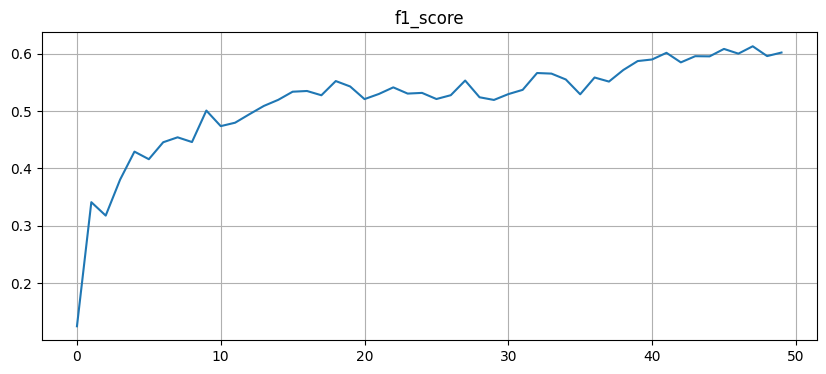

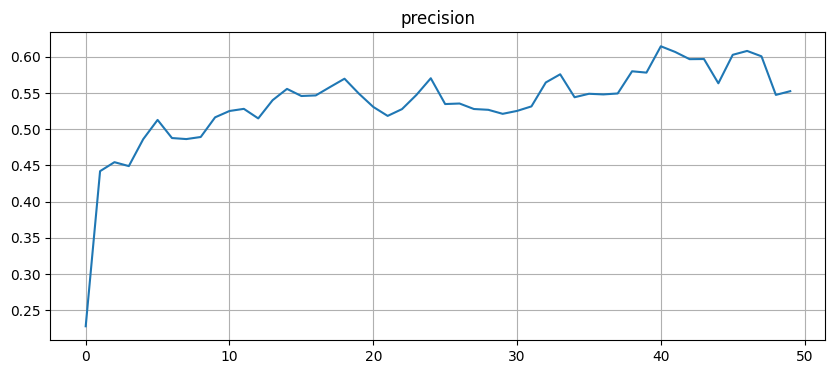

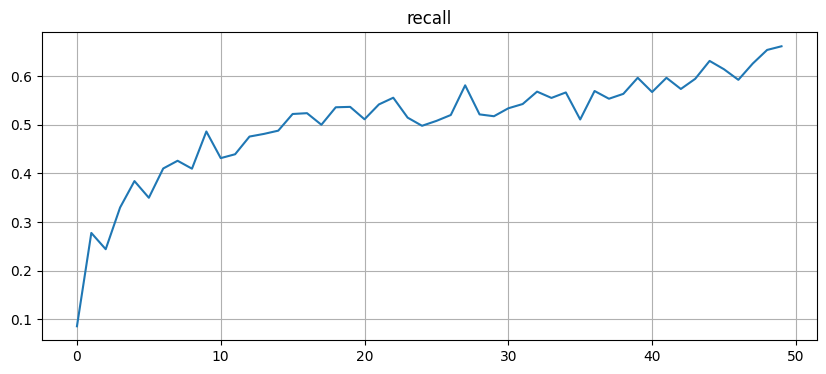

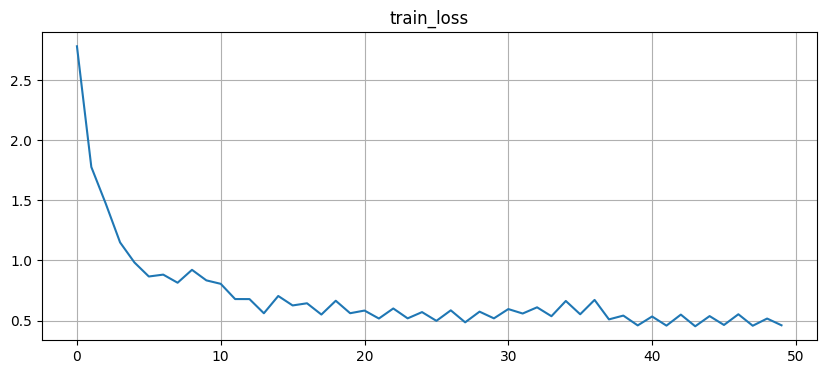

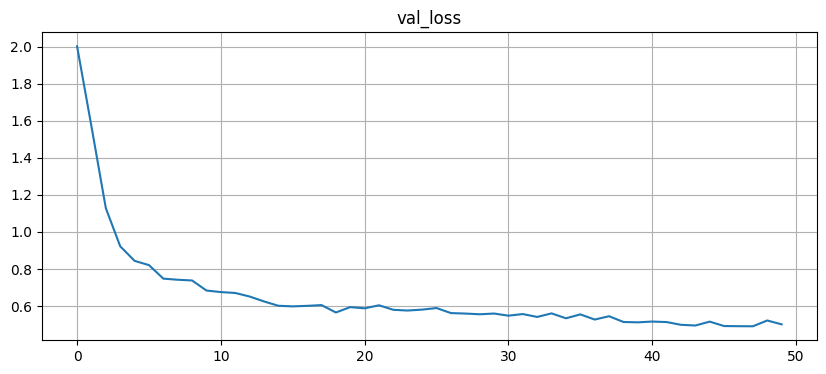

In [9]:
for i, (name, history) in enumerate (sorted (metrics.items ())):
    #plt.plot (1, len (metrics), i + 1)
    plt.figure (figsize = (10, 4))
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
    plt.show ()

In [10]:

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation wmax: ', sanity_check (val_preds, val_labels_fromdata))

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Test wmax: ', sanity_check (val_preds, val_labels_fromdata))


100%|██████████| 25/25 [01:09<00:00,  2.77s/it]


Validation wmax:  (0.5525672371638142, 0.6613712374581939, 0.60209324452902)


100%|██████████| 29/29 [00:38<00:00,  1.33s/it]


Test wmax:  (0.5754687003495392, 0.6899047619047619, 0.6275121275121275)


In [28]:


val_data_next = tokenizer (val_parallel_text, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')

next_val_dataset = Seq2SeqDataset (val_data_next, val_labels)
next_val_loader = DataLoader (next_val_dataset, batch_size = EVAL_BATCH_SIZE)

val_parallel_text_new_next = attach_model_foundings (val_parallel_text, next_val_loader, model)

val_data_next = tokenizer (val_parallel_text_new_next, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
next_val_dataset = Seq2SeqDataset (val_data_next, val_labels)
next_val_loader = DataLoader (next_val_dataset, batch_size = EVAL_BATCH_SIZE)

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (next_val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation wmax: ', sanity_check (val_preds, val_labels_fromdata))

595it [00:00, 2564.62it/s]
100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


Validation wmax:  (0.5436105476673428, 0.6722408026755853, 0.6011214953271028)


In [25]:
tokenizer.decode (val_data_next ['input_ids'] [1])

'Лингвистический процессор Semantix предназначен для областей, где требуется автоматическая формализация потоков текстов на естественном языке: резюме, сообщения СМИ, информационно-рекламные материалы, почтовые сообщения, сводки происшествий, справки по уголовным делам, архивные материалы и др. <extra_id_1> <extra_id_0> Лингвистический процессор Semantix <extra_id_0> процессор Semantix <extra_id_0> автоматическая формализация потоков текстов <extra_id_0> естественном языке <extra_id_0> языке <extra_id_0> резюме <extra_id_0> сообщения <extra_id_0> СМИ <extra_id_0> информационно-рекламные материалы <extra_id_0> почтовые сообщения <extra_id_0> сообщения <extra_id_0> архивные материалы</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [ ]:
tokenizer.decode (next_val_dataset [1] ['input_ids'])

In [27]:
tokenizer.decode (val_preds [0])

'<pad> <extra_id_1> <extra_id_0> Заударный слог <extra_id_0> слог <extra_id_0> ровным движением тона <extra_id_0> тона</s><pad>'

https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/T5/Fine_tune_CodeT5_for_generating_docstrings_from_Ruby_code.ipynb#scrollTo=wvRHDkCIS91f

In [11]:
print separator

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (358543031.py, line 1)

In [ ]:
# saved first corrector code

kf = KFold (n_splits = NUM_OF_SPLITS)

data = df ['text']
labels = df ['label']

test_indices = list (kf.split (data))

inc_term_set = set ([''])
for iteration, (train_index, test_index) in enumerate (test_indices):
    X_curr = data [test_index]
    y_curr = labels [test_index]

    train_data_lst = X_curr.tolist ()
    train_labels_lst = y_curr.tolist ()
    parallel_text, parallel_labels = create_parallels (train_data_lst, train_labels_lst)

    train_data = tokenizer (parallel_text, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
    train_labels = tokenizer (parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

    if ENABLE_LABEL_FIX:
        replaced = replace_padding (train_labels)
        train_labels = replaced

    train_dataset = Seq2SeqDataset (train_data, train_labels)
    train_loader = DataLoader (train_dataset, batch_size = EVAL_BATCH_SIZE)

    parallel_text_new = attach_model_foundings (parallel_text, train_loader, model)

    train_data = tokenizer (parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
    train_dataset = Seq2SeqDataset (train_data, train_labels)
    train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)

    for epoch in range (LOCAL_NUM_EPOCHS):
        model.train ()  # Устанавливаем модель в режим обучения
        total_loss = 0
        
        for batch in tqdm (train_loader):
            
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels_fromdata = batch ['labels'].to (model.device)

            #outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            loss = outputs.loss   ## DOUBLE CHECK if padding ...
            total_loss += loss.item ()

            loss.backward ()  # Обратное распространение
            optimizer.step ()  # Обновление параметров
            optimizer.zero_grad ()  # Обнуляем градиенты

            #scheduler.step ()  # Обновление learning rate
            torch.cuda.empty_cache ()
        

        avg_loss = total_loss / len (train_loader)

        metrics ['train_loss'].append ((epoch + iteration * LOCAL_NUM_EPOCHS, avg_loss))

        # Оценка на валидационной выборке
        model.eval ()  # Устанавливаем модель в режим оценки
        val_preds, val_labels = [], []
        total_val_loss = 0

        with torch.no_grad ():
            for batch in val_loader:
                input_ids = batch ['input_ids'].to (model.device)
                attention_mask = batch ['attention_mask'].to (model.device)
                labels_fromdata = batch ['labels'].to (model.device)

                outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

                total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata).loss.item ()

                val_preds.extend (outputs)
                val_labels.extend (labels_fromdata)
                torch.cuda.empty_cache ()

        avg_val_loss = total_val_loss / len (val_loader)

        prec, recl, f1sc = sanity_check (val_preds, val_labels)

        metrics ['val_loss'].append ((epoch + iteration * LOCAL_NUM_EPOCHS, avg_val_loss))
        metrics ['precision'].append ((epoch + iteration * LOCAL_NUM_EPOCHS, prec))
        metrics ['recall'].append ((epoch + iteration * LOCAL_NUM_EPOCHS, recl))
        metrics ['f1_score'].append ((epoch + iteration * LOCAL_NUM_EPOCHS, f1sc))

        print (f'Epoch {(epoch + 1) + iteration * LOCAL_NUM_EPOCHS} / {NUM_OF_SPLITS * LOCAL_NUM_EPOCHS}, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')
        
        torch.cuda.empty_cache ()


    for line in parallel_labels:
        inc_term_set |= set (line.split (SEP_TOKEN))
    inc_term_set -= set ([''])
    inc_term_set -= set ([LABEL_PREFIX_TOKEN])
    print (f'Уникальных терминов в {iteration + 1}-м тренировочном наборе: {len (inc_term_set)}.')

In [ ]:
view_at_loss = True
num_passed_epochs = 0

In [ ]:
kf = KFold (n_splits = NUM_OF_SPLITS)

data = df ['text']
labels = df ['label']

inc_term_set = set ([''])

#prev_f1_score = 0
prev_metric = 1000000 if view_at_loss else 0
for iteration, (train_index, test_index) in enumerate (kf.split (data)):
    X_curr = data [test_index]
    y_curr = labels [test_index]

    train_data_lst = X_curr.tolist ()
    train_labels_lst = y_curr.tolist ()
    parallel_text, parallel_labels = create_parallels (train_data_lst, train_labels_lst)

    parallel_text_new = attach_dictionary_foundings (parallel_text, inc_term_set)

    train_data = tokenizer (parallel_text_new, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
    train_labels = tokenizer (parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')
    
    if ENABLE_LABEL_FIX:
        replaced = replace_padding (train_labels)
        train_labels = replaced

    train_dataset = Seq2SeqDataset (train_data, train_labels)
    train_loader = DataLoader (train_dataset, batch_size = BATCH_SIZE, shuffle = True)
    
    prev_model = deepcopy (model.state_dict ())
    prev_optimizer = deepcopy (optimizer.state_dict ())
    epoch = 0
    #for epoch in range (LOCAL_NUM_EPOCHS):
    while True:

        model.train ()  # Устанавливаем модель в режим обучения
        total_loss = 0
        
        for batch in tqdm (train_loader):
            
            input_ids = batch ['input_ids'].to (model.device)
            attention_mask = batch ['attention_mask'].to (model.device)
            labels_fromdata = batch ['labels'].to (model.device)

            #outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            outputs = model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata)
            loss = outputs.loss   ## DOUBLE CHECK if padding ...
            total_loss += loss.item ()

            loss.backward ()  # Обратное распространение
            optimizer.step ()  # Обновление параметров
            optimizer.zero_grad ()  # Обнуляем градиенты

            #scheduler.step ()  # Обновление learning rate
            torch.cuda.empty_cache ()
        

        avg_loss = total_loss / len (train_loader)

        

        # Оценка на валидационной выборке
        model.eval ()  # Устанавливаем модель в режим оценки
        val_preds, val_labels = [], []
        total_val_loss = 0

        with torch.no_grad ():
            for batch in val_loader:
                input_ids = batch ['input_ids'].to (model.device)
                attention_mask = batch ['attention_mask'].to (model.device)
                labels_fromdata = batch ['labels'].to (model.device)

                outputs = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

                total_val_loss += model (input_ids = input_ids, attention_mask = attention_mask, labels = labels_fromdata).loss.item ()

                val_preds.extend (outputs)
                val_labels.extend (labels_fromdata)
                torch.cuda.empty_cache ()

        avg_val_loss = total_val_loss / len (val_loader)

        prec, recl, f1sc = sanity_check (val_preds, val_labels)

        print (f'Epoch {(epoch + 1) + num_passed_epochs} / ---, Loss: {avg_loss:.4f}, Validation loss: {avg_val_loss:.4f}, {prec} / {recl} / {f1sc}')
        
        torch.cuda.empty_cache ()

        ### WHAT
        if (view_at_loss and prev_metric < avg_val_loss) or (not view_at_loss and prev_metric > f1sc):
            model.load_state_dict (prev_model)
            optimizer.load_state_dict (prev_optimizer)
            num_passed_epochs += epoch
            break
        epoch += 1
        prev_metric = avg_val_loss if view_at_loss else f1sc
        prev_model = deepcopy (model.state_dict ())
        prev_optimizer = deepcopy (optimizer.state_dict ())

        metrics ['train_loss'].append ((epoch + num_passed_epochs, avg_loss))
        metrics ['val_loss'].append ((epoch + num_passed_epochs, avg_val_loss))
        metrics ['precision'].append ((epoch + num_passed_epochs, prec))
        metrics ['recall'].append ((epoch + num_passed_epochs, recl))
        metrics ['f1_score'].append ((epoch + num_passed_epochs, f1sc))
        

    for line in parallel_labels:
        inc_term_set |= set (line.split (SEP_TOKEN))
    inc_term_set -= set ([''])
    inc_term_set -= set ([LABEL_PREFIX_TOKEN])
    print (f'Уникальных терминов в {iteration + 1}-м тренировочном наборе: {len (inc_term_set)}.')

In [ ]:
print (metrics)

In [ ]:
for i, (name, history) in enumerate (sorted (metrics.items ())):
    #plt.plot (1, len (metrics), i + 1)
    plt.figure (figsize = (10, 4))
    plt.title (name)
    plt.plot (*zip (*history))
    plt.grid ()
    plt.show ()

In [ ]:


model.eval ()  # Устанавливаем модель в режим оценки
val_preds, val_labels_fromdata = [], []

with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation: ', sanity_check (val_preds, val_labels_fromdata))


val_preds, val_labels_fromdata = [], []

with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Test: ', sanity_check (val_preds, val_labels_fromdata))


In [ ]:

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation wmax: ', sanity_check (val_preds, val_labels_fromdata))

val_preds, val_labels_fromdata = [], []
with torch.no_grad ():
    for batch in tqdm (test_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels_fromdata.extend (labels)
        torch.cuda.empty_cache ()

    print ('Test wmax: ', sanity_check (val_preds, val_labels_fromdata))


In [ ]:
#model.save_pretrained ('./rut5base_fulltrain_novalid_dictionary_postfix')
#tokenizer.save_pretrained ('./rut5base_fulltrain_novalid_dictionary_postfix')

In [ ]:
'''

Validation wmax:  (0.6070240295748613, 0.6864548494983278, 0.6443005689621345)
Test wmax:  (0.6368438428524266, 0.7348571428571429, 0.6823487796250443)

'''

In [ ]:
print (val_parallel_text [6])
predicted_set = get_set (val_preds [6], ground_truth = False)
predicted_set

In [ ]:
#model.save_pretrained('./rut5small_fulltrain_dictpostfix_avg7209-7591')
#tokenizer.save_pretrained('./rut5small_fulltrain_dictpostfix_avg7209-7591')

In [ ]:
print 5

In [ ]:
model = MT5ForConditionalGeneration.from_pretrained ('./coint_rut5small_finetune_fulltrain_novalid')

model.to (device)
print (model.device)

In [ ]:
val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (model.device)
        attention_mask = batch ['attention_mask'].to (model.device)
        labels = batch ['labels'].to (model.device)
        out = model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation augmented: ', sanity_check (val_preds, val_labels))

In [ ]:

parallel_text_val_augmented = []
for i in range (len (val_preds)):
    predicted_set = get_set (val_preds [i], ground_truth = False)
    parallel_text_val_augmented.append (make_attachment (val_parallel_text [i], predicted_set))

val_data = tokenizer (parallel_text_val_augmented, padding = 'max_length', truncation = True, max_length = SEQ_MAX_LENGTH, return_tensors = 'pt')
val_labels = tokenizer (val_parallel_labels, padding = 'max_length', truncation = True, max_length = ANSWER_MAX_LENGTH, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    rse = replace_padding (val_labels)
    val_labels = rse

val_dataset = Seq2SeqDataset (val_data, val_labels)

val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)

In [ ]:
prev_model = MT5ForConditionalGeneration.from_pretrained ('./coint_rut5small_finetune_fulltrain_novalid')

prev_model.to (device)
print (prev_model.device)

In [ ]:

val_data = tokenizer (parallel_text_val, padding = 'max_length', truncation = True, max_length = 150, return_tensors = 'pt')
val_labels = tokenizer (parallel_label_val, padding = 'max_length', truncation = True, max_length = 150, return_tensors = 'pt')

if ENABLE_LABEL_FIX:
    rse = replace_padding (val_labels)
    val_labels = rse

val_dataset = Seq2SeqDataset (val_data, val_labels)

val_loader = DataLoader (val_dataset, batch_size = EVAL_BATCH_SIZE)

In [ ]:
val_preds, val_labels = [], []
with torch.no_grad ():
    for batch in tqdm (val_loader):
        input_ids = batch ['input_ids'].to (prev_model.device)
        attention_mask = batch ['attention_mask'].to (prev_model.device)
        labels = batch ['labels'].to (prev_model.device)
        out = prev_model.generate (input_ids = input_ids, attention_mask = attention_mask, max_length=SEQ_MAX_LENGTH)

        val_preds.extend (out)
        val_labels.extend (labels)
        torch.cuda.empty_cache ()

    print ('Validation augmented: ', sanity_check (val_preds, val_labels))

In [ ]:
#model.save_pretrained('./rut5small_fulltrain_novalid_dictionary_postfix')
#tokenizer.save_pretrained('./rut5small_fulltrain_novalid_dictionary_postfix')